In [1]:
import sys
sys.path.append("../../")
DATA_PATH = "../../data/"
SAVE_PATH = "../../plots"

import abm_py as abm
import matplotlib.pyplot as plt
import numpy as np
import py_common.utility as utility
from py_common.units import *
from py_common.scattering_dependence import *

In [2]:
import re

class Parameter(Enum):
    MagneticField = 1,
    ScalingFactor = 2,

def get_bound_energies(filename, parameter = Parameter.MagneticField):
    results = []
    energy_unit = None

    # Define a pattern that matches numbers (with optional scientific notation)
    num_pattern = r"[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?"
    
    # Regular expression for magnetic field lines
    field = "MAGNETIC Z FIELD"
    match parameter:
        case Parameter.MagneticField:
            field = "MAGNETIC Z FIELD"
        case Parameter.ScalingFactor:
            field = "POTL SCALING FACTOR"

    field_re = re.compile(rf"EFV SET\s+\d+:\s+{field} =\s+({num_pattern})")
    
    # Regular expression for energy lines.
    # This regex captures both the energy value and the energy unit.
    energy_re = re.compile(
        r"CONVERGED ON STATE NUMBER\s+\d+\s+AT\s+.*?ENERGY\s*=\s*(?P<energy>" + num_pattern + r")\s*(?P<unit>[A-Za-z]+)"
    )

    current_field = None
    current_energies = []

    with open(filename, 'r') as file:
        for line in file:
            # Check for a magnetic field line.
            field_match = field_re.search(line)
            if field_match:
                # If we were collecting a block, save it before starting a new one.
                if current_field is not None:
                    results.append((float(current_field), current_energies))
                current_field = field_match.group(1)
                current_energies = []  # Reset energies for the new block.
                continue

            # Check for an energy line.
            energy_match = energy_re.search(line)
            if energy_match and current_field is not None:
                energy_value = energy_match.group("energy")
                unit = energy_match.group("unit")
                # Store the energy unit (assume it's the same throughout the file)
                if energy_unit is None:
                    energy_unit = unit
                elif energy_unit != unit:
                    print(f"Warning: Multiple energy units found! {energy_unit} vs {unit}")
                current_energies.append(float(energy_value))

    # Add the last block if present.
    if current_field is not None:
        results.append((float(current_field), current_energies))

    return results, energy_unit


# Levels

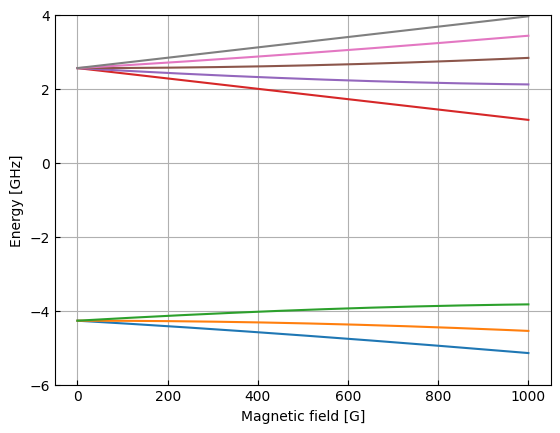

In [3]:
rb = abm.HifiProblemBuilder(1, 3)
rb.with_hyperfine_coupling(0.113990 * CMINV)

mag_fields = np.linspace(0, 1000, 500)
states = np.array(rb.build().states_range(mag_fields)) / GHZ

fig, ax = utility.plot()
ax.plot(mag_fields, states)
ax.set_ylim(-6, 4)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Energy [GHz]");

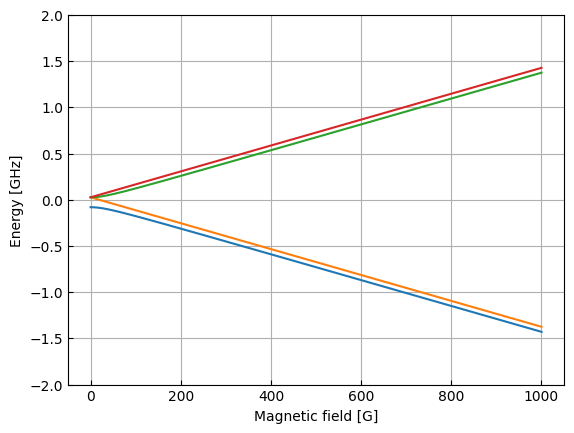

In [4]:
srf = abm.HifiProblemBuilder(1, 1)
srf.with_hyperfine_coupling((3.2383e-3 + 1.0096e-3 / 3.) * CMINV)

mag_fields = np.linspace(0, 1000, 500)
states = np.array(srf.build().states_range(mag_fields)) / GHZ

fig, ax = utility.plot()
ax.plot(mag_fields, states)
ax.set_ylim(-2, 2)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Energy [GHz]");

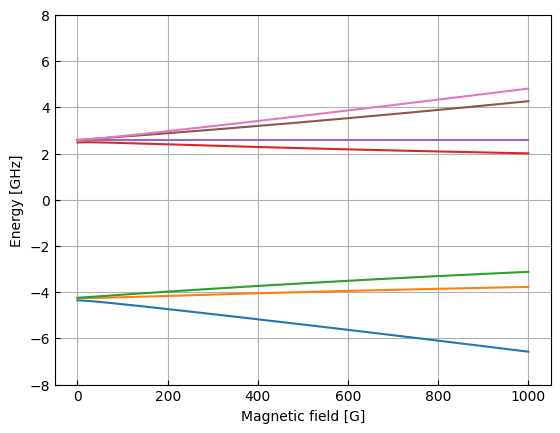

In [5]:
srf_rb = abm.DoubleHifiProblemBuilder(srf, rb)
srf_rb.with_projection(2)

mag_fields = np.linspace(0, 1000, 500)
states = np.array(srf_rb.build().states_range(mag_fields)) / GHZ

fig, ax = utility.plot()
ax.plot(mag_fields, states)
ax.set_ylim(-8, 8)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Energy [GHz]");

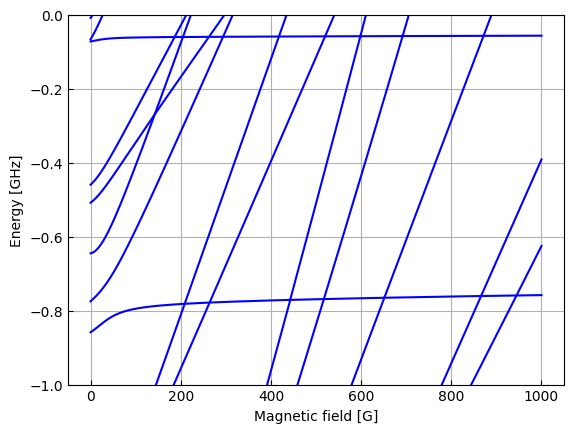

In [6]:
srf_rb_abm = abm.ABMProblemBuilder(srf, rb)
srf_rb_abm.with_projection(2)
singlet_energies = np.array([-10.09009577, 
    -7.703456668, -5.826296991, -3.714116651,
    -1.274587442, -1.121622475, -0.1274901975])[::-1] * GHZ
triplet_energies = np.array([-9.506727627,
    -6.949691334, -4.055884259, -2.739375494,
    -1.678314129, -0.7289760469, -5.0666087781E-02])[::-1] * GHZ

fc_factors = np.identity(len(singlet_energies))


srf_rb_abm.with_vibrational(singlet_energies, triplet_energies, fc_factors.flatten())

states_abm = np.array(srf_rb_abm.build().states_range(mag_fields)) / GHZ

fig, ax = utility.plot()
ax.plot(mag_fields, states_abm - states[:, 0:1], color = "blue")
ax.set_ylim(-1, 0)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Energy [GHz]");

# Potentials

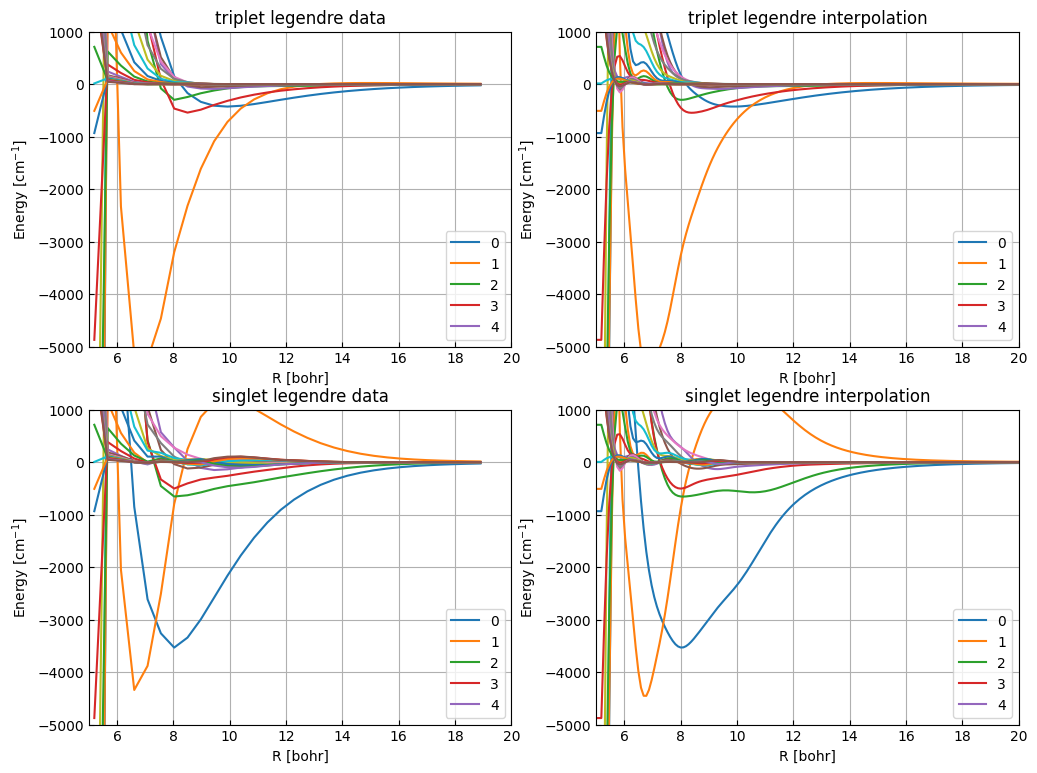

In [23]:
files = [
    "SrF_Rb_triplet_dec.dat",
    "SrF_Rb_triplet_dec_interpolated.dat",
    "SrF_Rb_singlet_dec.dat",
    "SrF_Rb_singlet_dec_interpolated.dat"
]

titles = [
    "triplet legendre data",
    "triplet legendre interpolation",
    "singlet legendre data",
    "singlet legendre interpolation"
]

fig, axes = utility.plot_many(2, 2, (12, 9))

for i, ax in enumerate(axes):
    data = utility.load(f"{DATA_PATH}/{files[i]}")
    scalings = data[:, 0]
    values_legendre = data[:, 1:]

    ax.plot(scalings, values_legendre / CMINV)
    ax.legend([str(i) for i in range(5)])
    ax.set_title(titles[i])
    ax.set_xlabel("R [bohr]")
    ax.set_ylabel(r"Energy [cm$^{-1}$]")

    ax.set_xlim(5, 20)
    ax.set_ylim(-5000, 1000)

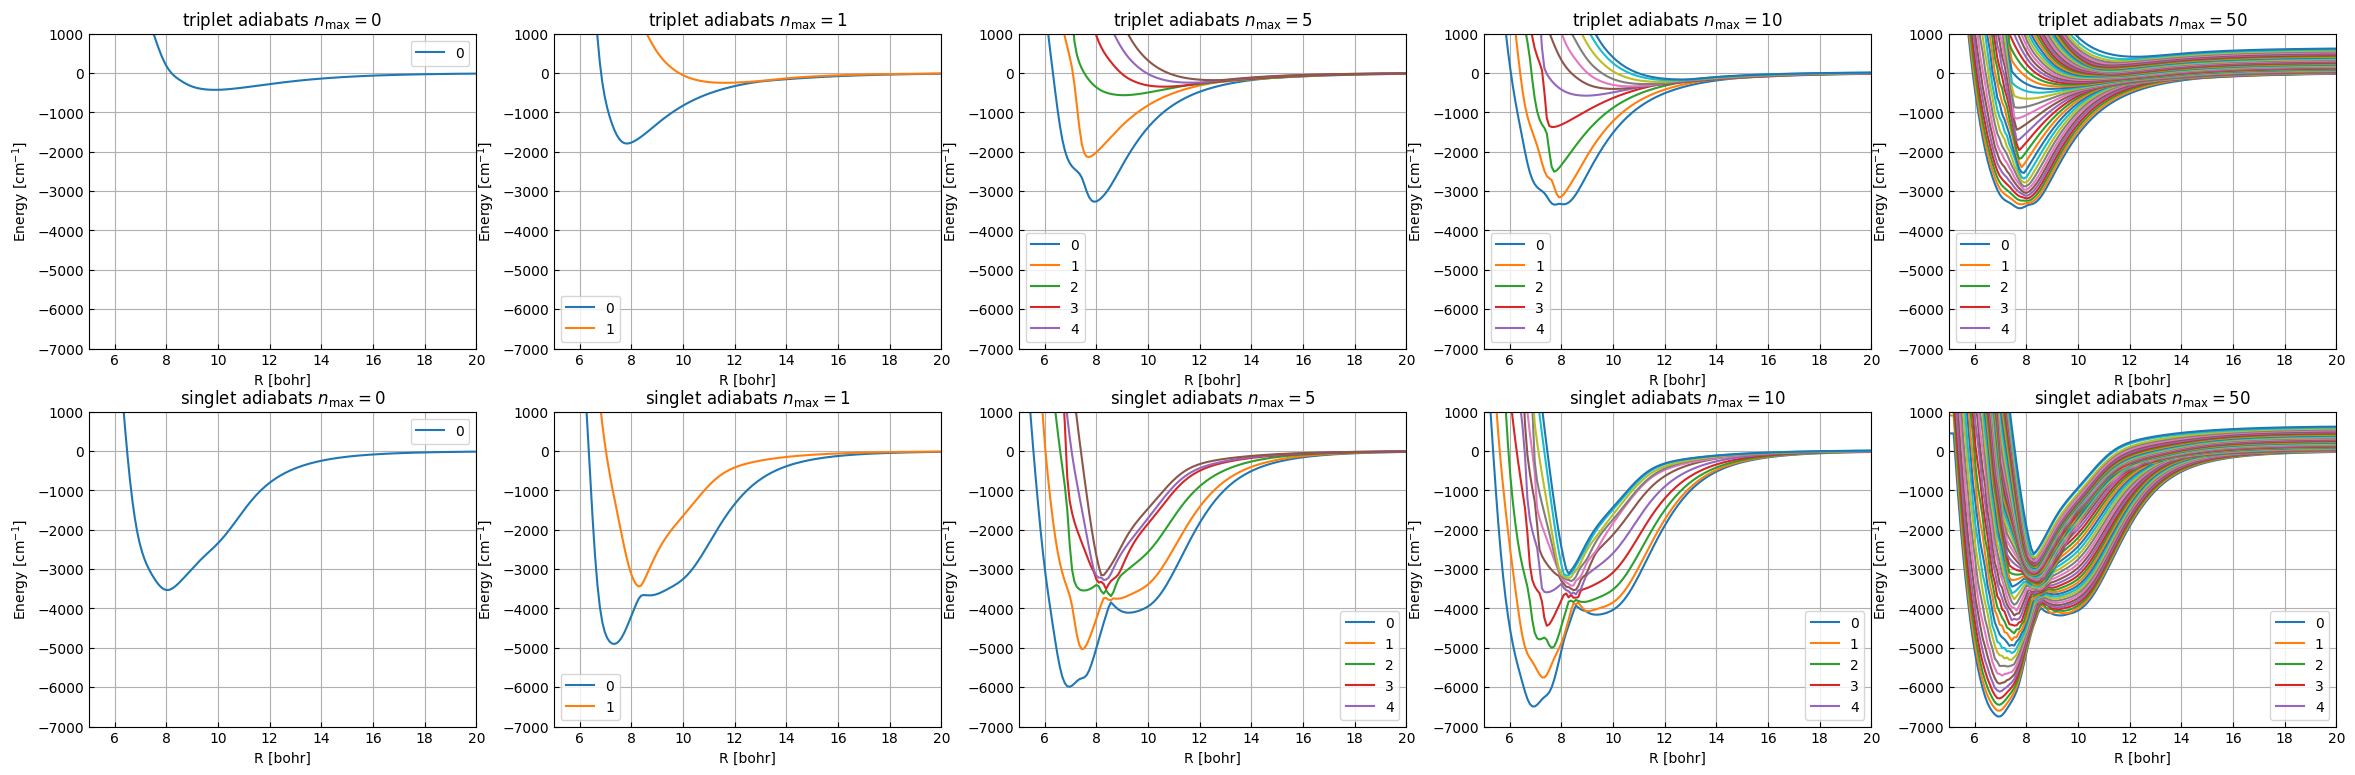

In [26]:
# adiabats

files = [
    "SrF_Rb_triplet_adiabat_n_0.dat",
    "SrF_Rb_triplet_adiabat_n_1.dat",
    "SrF_Rb_triplet_adiabat_n_5.dat",
    "SrF_Rb_triplet_adiabat_n_10.dat",
    "SrF_Rb_triplet_adiabat_n_50.dat",

    "SrF_Rb_singlet_adiabat_n_0.dat",
    "SrF_Rb_singlet_adiabat_n_1.dat",
    "SrF_Rb_singlet_adiabat_n_5.dat",
    "SrF_Rb_singlet_adiabat_n_10.dat",
    "SrF_Rb_singlet_adiabat_n_50.dat",
]

titles = [
    r"triplet adiabats $n_\text{max} = 0$",
    r"triplet adiabats $n_\text{max} = 1$",
    r"triplet adiabats $n_\text{max} = 5$",
    r"triplet adiabats $n_\text{max} = 10$",
    r"triplet adiabats $n_\text{max} = 50$",

    r"singlet adiabats $n_\text{max} = 0$",
    r"singlet adiabats $n_\text{max} = 1$",
    r"singlet adiabats $n_\text{max} = 5$",
    r"singlet adiabats $n_\text{max} = 10$",
    r"singlet adiabats $n_\text{max} = 50$",
]

fig, axes = utility.plot_many(2, 5, (29, 9))

for i, ax in enumerate(axes):
    data = utility.load(f"{DATA_PATH}/{files[i]}")
    scalings = data[:, 0]
    values_legendre = data[:, 1:]

    ax.plot(scalings, values_legendre / CMINV)
    ax.legend([str(i) for i in range(5)])
    ax.set_title(titles[i])
    ax.set_xlabel("R [bohr]")
    ax.set_ylabel(r"Energy [cm$^{-1}$]")

    ax.set_xlim(5, 20)
    ax.set_ylim(-7000, 1000)

# Cross sections

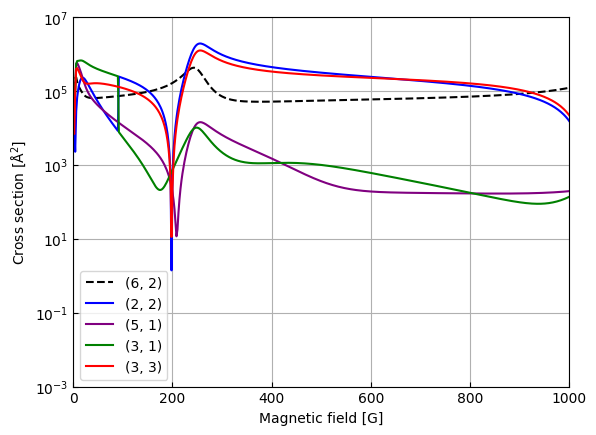

In [5]:
data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scatterings_n_0.json")

fig, ax = utility.plot()
ax.plot(data.parameters, data.elastic_cross_sections() / ANGS**2, linestyle = "--", color = "black", label = "(6, 2)")
ax.plot(data.parameters, data.inelastic_cross_sections(0) / ANGS**2, color = "blue", label = "(2, 2)")
ax.plot(data.parameters, data.inelastic_cross_sections(3) / ANGS**2, color = "purple", label = "(5, 1)")
ax.plot(data.parameters, data.inelastic_cross_sections(1) / ANGS**2, color = "green", label = "(3, 1)")
ax.plot(data.parameters, data.inelastic_cross_sections(2) / ANGS**2, color = "red", label = "(3, 3)")

ax.set_yscale("log")
ax.set_ylim(1e-3, 1e7)
ax.set_xlim(0, 1000)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel(r"Cross section [Å$^2$]")
ax.legend();
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_scatterings_n_max_0.pdf");

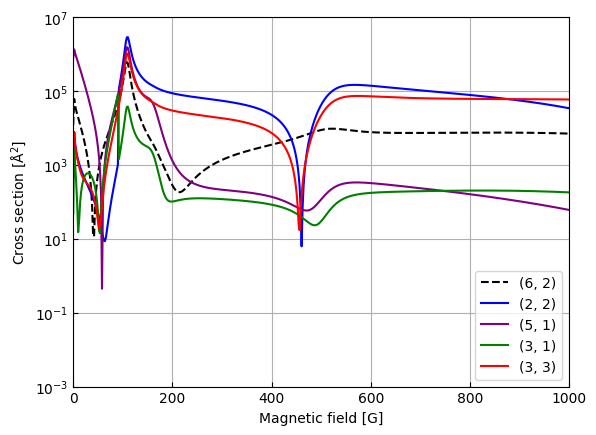

In [ ]:
data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scatterings.json")

fig, ax = utility.plot()
ax.plot(data.parameters, data.elastic_cross_sections() / ANGS**2, linestyle = "--", color = "black", label = "(6, 2)")
ax.plot(data.parameters, data.inelastic_cross_sections(0) / ANGS**2, color = "blue", label = "(2, 2)")
ax.plot(data.parameters, data.inelastic_cross_sections(3) / ANGS**2, color = "purple", label = "(5, 1)")
ax.plot(data.parameters, data.inelastic_cross_sections(1) / ANGS**2, color = "green", label = "(3, 1)")
ax.plot(data.parameters, data.inelastic_cross_sections(2) / ANGS**2, color = "red", label = "(3, 3)")

ax.set_yscale("log")
ax.set_ylim(1e-3, 1e7)
ax.set_xlim(0, 1000)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel(r"Cross section [Å$^2$]")
ax.legend();
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_scatterings_n_max_10.pdf");

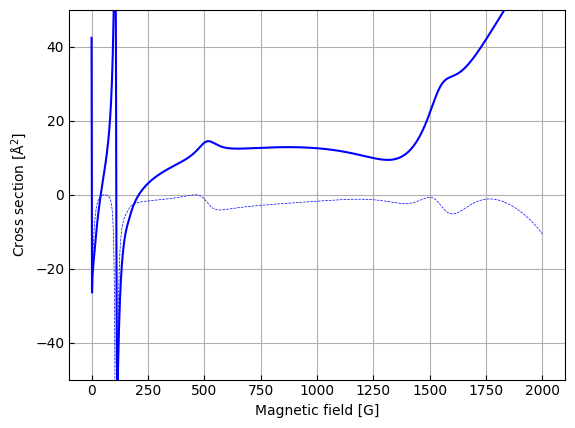

In [ ]:
data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scatterings.json")

fig, ax = utility.plot()
ax.plot(data.parameters, data.s_lengths().real, color = "blue")
ax.plot(data.parameters, data.s_lengths().imag, color = "blue", linestyle="--", linewidth = 0.5)

ax.set_ylim(-50, 50)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Scattering length [bohr]");

# Scattering lengths

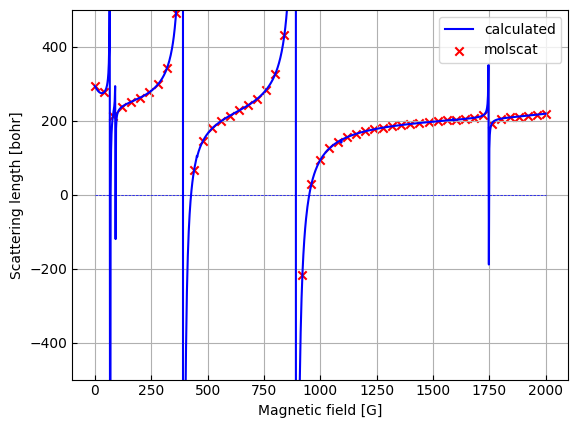

In [ ]:
data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scatterings_n_0_ground.json")

fig, ax = utility.plot()
ax.plot(data.parameters, data.s_lengths().real, color = "blue", label="calculated")
ax.plot(data.parameters, data.s_lengths().imag, color = "blue", linestyle="--", linewidth = 0.5)

try:
	data = read_molscat_field_dependence(f"{DATA_PATH}/srf_rb_n_0_molscat.3")
	ax.scatter(data[::2, 0], data[::2, 1], color = "red", marker="x", label="molscat")
except:
	pass

ax.set_ylim(-500, 500)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Scattering length [bohr]")
ax.legend();
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_scattering_n_0.pdf")

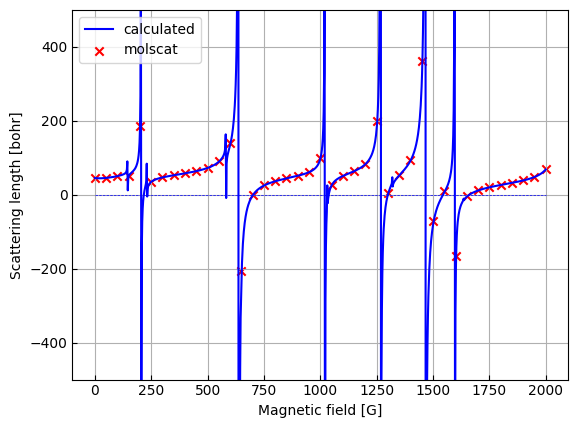

In [ ]:
data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scatterings_ground_n_max_10_n_tot_0.json")

fig, ax = utility.plot()
ax.plot(data.parameters, data.s_lengths().real, color = "blue", label = "calculated")
ax.plot(data.parameters, data.s_lengths().imag, color = "blue", linestyle="--", linewidth = 0.5)

try:
	data = read_molscat_field_dependence(f"{DATA_PATH}/srf_rb_n_10_molscat.3")
	ax.scatter(data[:, 0], data[:, 1], color = "red", marker="x", label="molscat")
except:
	pass

ax.set_ylim(-500, 500)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Scattering length [bohr]")
ax.legend();

# fig.savefig(f"{SAVE_PATH}/SrF_Rb_scattering_n_10.pdf")

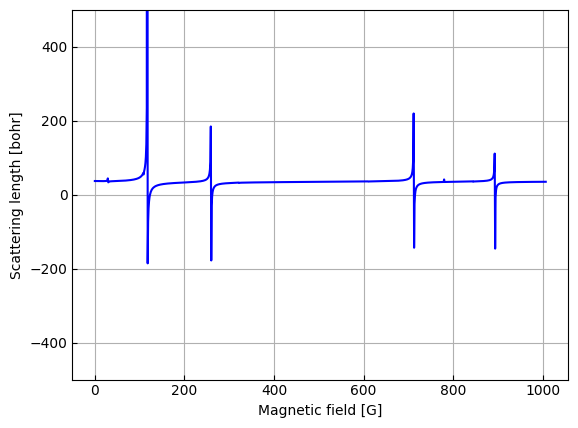

In [ ]:
filename = f"{DATA_PATH}/molscat_n_max_175.dat"
data = np.loadtxt(filename, delimiter="\t", skiprows=1)

fig, ax = utility.plot()
ax.plot(data[:, 1], data[:, 2], color = "blue")

ax.set_ylim(-500, 500)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Scattering length [bohr]");

# fig.savefig(f"{SAVE_PATH}/SrF_Rb_scattering_n_175.pdf")

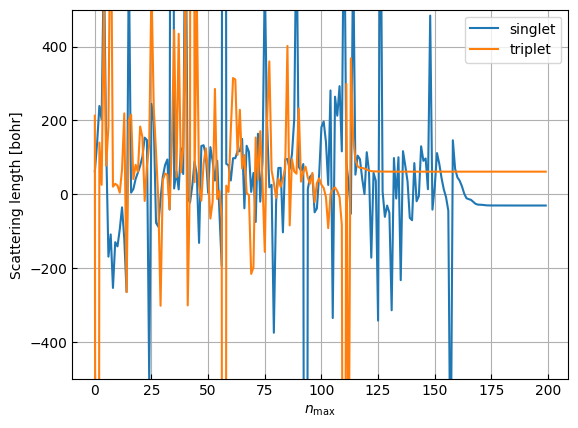

In [ ]:
data = utility.load(f"{DATA_PATH}/srf_rb_potential_scattering_convergence.dat")
scalings = data[:, 0]
singlet = data[:, 1]
triplet = data[:, 2]

fig, ax = utility.plot()
ax.plot(scalings, singlet, label = "singlet")
ax.plot(scalings, triplet, label = "triplet")

ax.set_ylim(-500, 500)
ax.set_xlabel(r"$n_\text{max}$")
ax.set_ylabel("Scattering length [bohr]")
ax.legend();

# fig.savefig(f"{SAVE_PATH}/SrF_Rb_triplet_singlet_convergence.pdf")

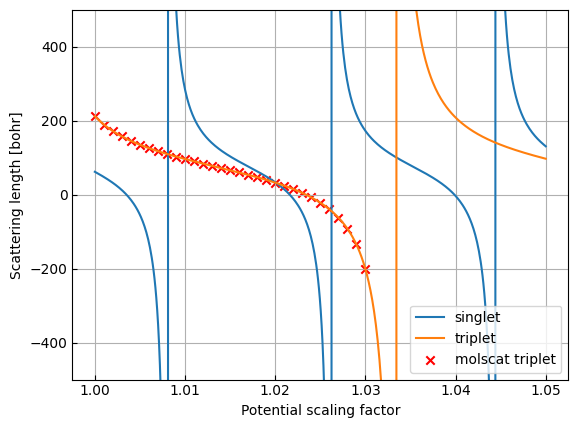

In [ ]:
data = utility.load(f"{DATA_PATH}/srf_rb_potential_scaling_n_max_0.dat")
scalings = data[:, 0]
singlet = data[:, 1]
triplet = data[:, 2]

fig, ax = utility.plot()
ax.plot(scalings, singlet, label = "singlet")
ax.plot(scalings, triplet, label = "triplet")

try:
	data = read_molscat_field_dependence(f"{DATA_PATH}/srf_rb_triplet_n_0_scaling.3", ParameterType.Scaling)
	ax.scatter(data[:, 0], data[:, 1], color = "red", marker="x", label="molscat triplet")
except:
	pass

ax.set_ylim(-500, 500)
ax.set_xlabel("Potential scaling factor")
ax.set_ylabel("Scattering length [bohr]")
ax.legend();
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_n_0.pdf")

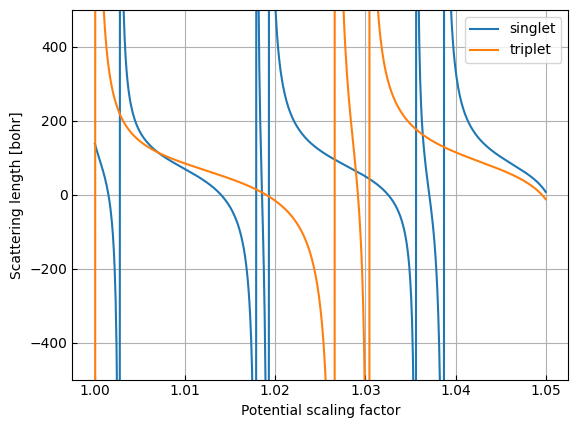

In [ ]:
data = utility.load(f"{DATA_PATH}/srf_rb_potential_scaling_n_max_1.dat")
scalings = data[:, 0]
singlet = data[:, 1]
triplet = data[:, 2]

fig, ax = utility.plot()
ax.plot(scalings, singlet)
ax.plot(scalings, triplet)

ax.set_ylim(-500, 500)
ax.set_xlabel("Potential scaling factor")
ax.set_ylabel("Scattering length [bohr]")
ax.legend(["singlet", "triplet"]);
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_n_1.pdf")

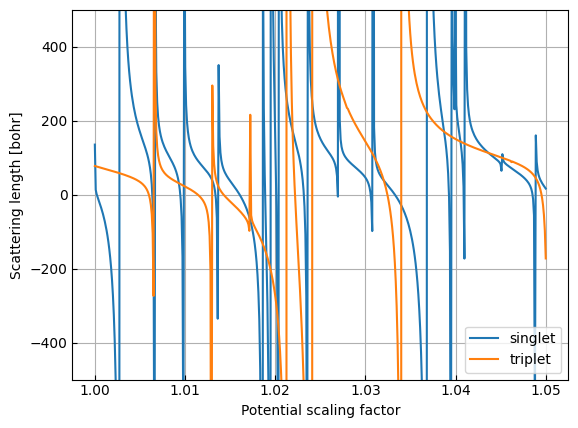

In [ ]:
data = utility.load(f"{DATA_PATH}/srf_rb_potential_scaling_n_max_5.dat")
scalings = data[:, 0]
singlet = data[:, 1]
triplet = data[:, 2]

fig, ax = utility.plot()
ax.plot(scalings, singlet)
ax.plot(scalings, triplet)

ax.set_ylim(-500, 500)
ax.set_xlabel("Potential scaling factor")
ax.set_ylabel("Scattering length [bohr]")
ax.legend(["singlet", "triplet"]);
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_n_5.pdf")

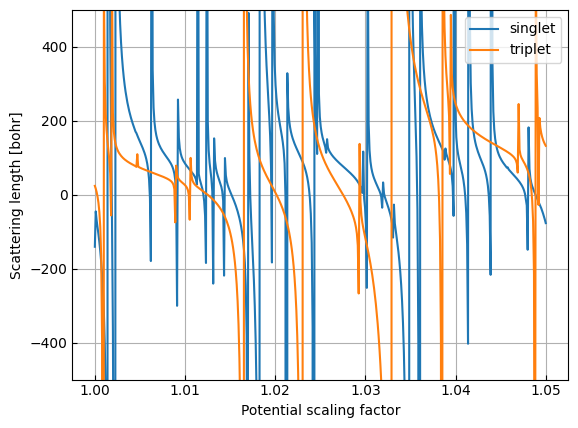

In [ ]:
data = utility.load(f"{DATA_PATH}/srf_rb_potential_scaling_n_max_10.dat")
scalings = data[:, 0]
singlet = data[:, 1]
triplet = data[:, 2]

fig, ax = utility.plot()
ax.plot(scalings, singlet)
ax.plot(scalings, triplet)

ax.set_ylim(-500, 500)
ax.set_xlabel("Potential scaling factor")
ax.set_ylabel("Scattering length [bohr]")
ax.legend(["singlet", "triplet"]);
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_n_10.pdf")

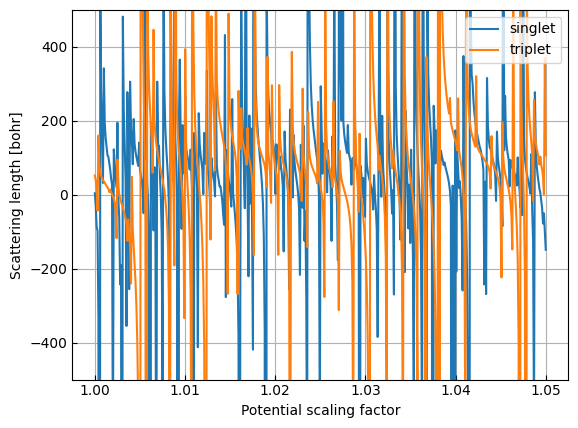

In [ ]:
data = utility.load(f"{DATA_PATH}/srf_rb_potential_scaling_n_max_50.dat")
scalings = data[:, 0]
singlet = data[:, 1]
triplet = data[:, 2]

fig, ax = utility.plot()
ax.plot(scalings, singlet)
ax.plot(scalings, triplet)

ax.set_ylim(-500, 500)
ax.set_xlabel("Potential scaling factor")
ax.set_ylabel("Scattering length [bohr]")
ax.legend(["singlet", "triplet"]);
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_n_50.pdf")

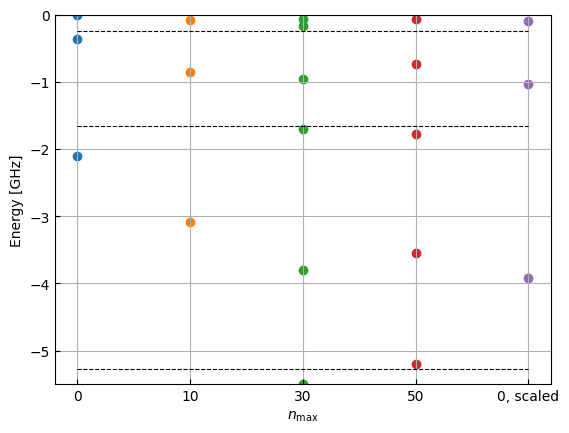

In [ ]:
n_maxes = [0, 10, 30, 50]
fig, ax = utility.plot()
for n_max in n_maxes:
    bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_{n_max}_triplet.dat")
    ax.scatter([str(n_max) for _ in bounds], bounds)

bounds_0_scaled = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_0_scaled_10_triplet.dat")
ax.scatter(["0, scaled" for _ in bounds_0_scaled], bounds_0_scaled)

x = ["0", "10", "30", "50", "0, scaled"]
for value in [0.246, 1.660, 5.280]:
	ax.plot(x, [-value for _ in range(5)], linestyle="--", color="black", linewidth=0.8)

ax.set_ylabel("Energy [GHz]")
ax.set_xlabel(r"$n_\text{max}$")
ax.set_ylim(-5.5, 0);
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_bounds_triplet.pdf")

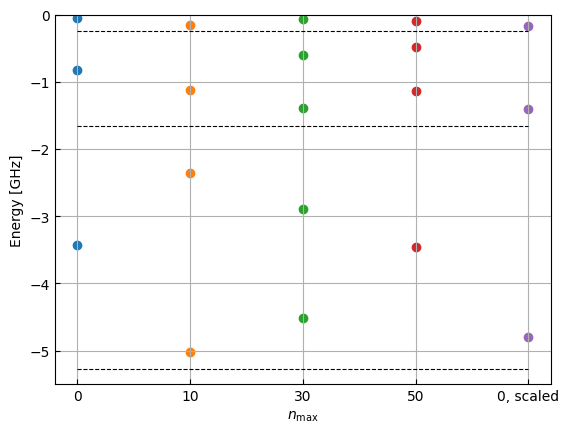

In [ ]:
n_maxes = [0, 10, 30, 50]
fig, ax = utility.plot()
for n_max in n_maxes:
    bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_{n_max}_singlet.dat")
    ax.scatter([str(n_max) for _ in bounds], bounds)

bounds_0_scaled = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_0_scaled_10_singlet.dat")
ax.scatter(["0, scaled" for _ in bounds_0_scaled], bounds_0_scaled)

x = ["0", "10", "30", "50", "0, scaled"]
for value in [0.246, 1.660, 5.280]:
	ax.plot(x, [-value for _ in range(5)], linestyle="--", color="black", linewidth=0.8)

ax.set_ylabel("Energy [GHz]")
ax.set_xlabel(r"$n_\text{max}$");
ax.set_ylim(-5.5, 0);
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_bounds_singlet.pdf")

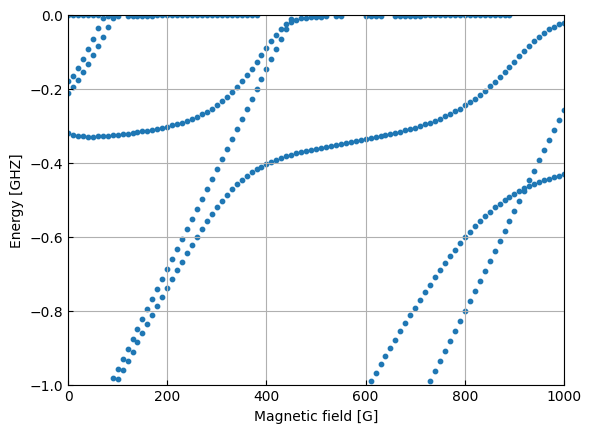

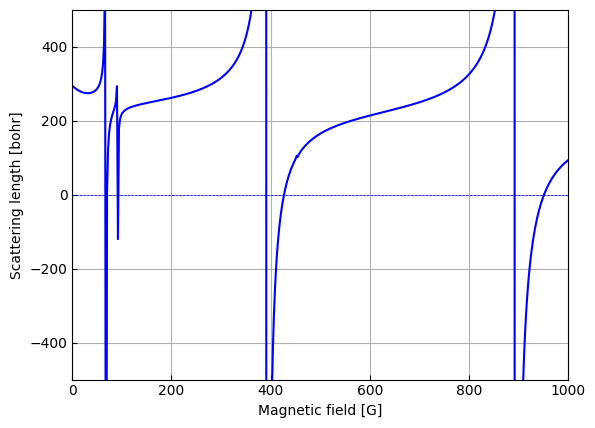

In [ ]:
filename = f"{DATA_PATH}/srf_rb_bounds_2.output"
data, unit = get_bound_energies(filename)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Magnetic field [G]")
ax.set_xlim(0, 1000)
ax.set_ylim(-1, 0)
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_bounds_n_0.pdf")

####################################

data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scatterings_n_0_ground.json")

fig, ax = utility.plot()
ax.plot(data.parameters, data.s_lengths().real, color = "blue")
ax.plot(data.parameters, data.s_lengths().imag, color = "blue", linestyle="--", linewidth = 0.5)

ax.set_ylim(-500, 500)
ax.set_xlim(0, 1000)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Scattering length [bohr]");
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_scattering_n_0_to_1000.pdf")

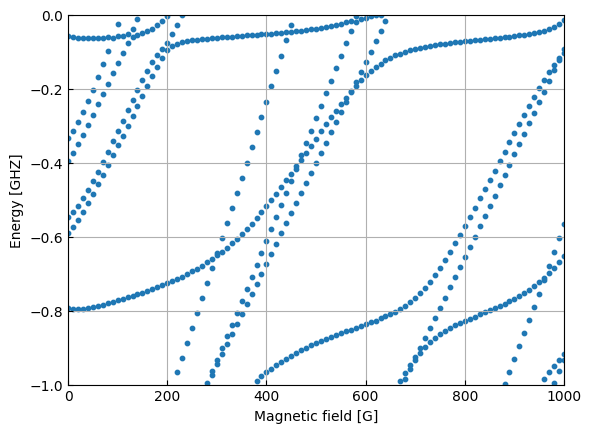

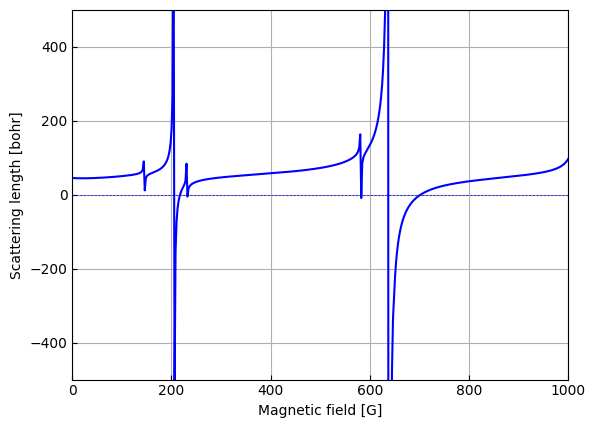

In [ ]:
filename = f"{DATA_PATH}/srf_rb_bounds_n_10.output"
data, unit = get_bound_energies(filename)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Magnetic field [G]")
ax.set_xlim(0, 1000)
ax.set_ylim(-1, 0)
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_bounds_n_10.pdf")

####################################

data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scatterings_ground_n_max_10_n_tot_0.json")

fig, ax = utility.plot()
ax.plot(data.parameters, data.s_lengths().real, color = "blue")
ax.plot(data.parameters, data.s_lengths().imag, color = "blue", linestyle="--", linewidth = 0.5)

ax.set_ylim(-500, 500)
ax.set_xlim(0, 1000)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Scattering length [bohr]");
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_scattering_n_10_to_1000.pdf")

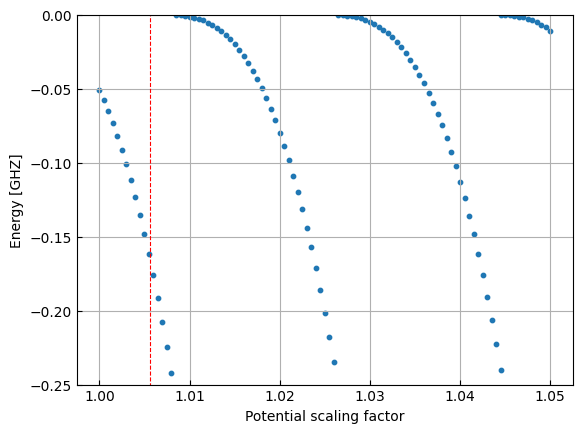

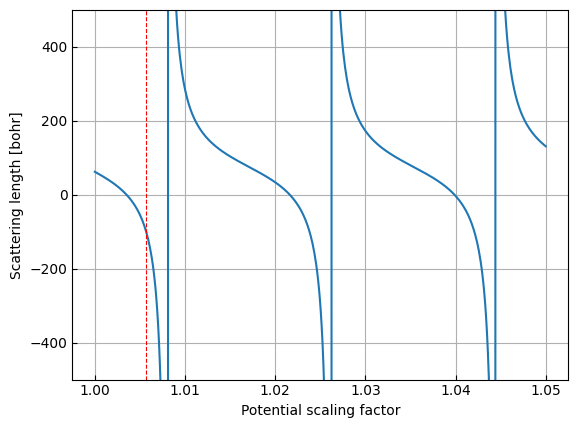

In [ ]:
filename = f"{DATA_PATH}/srf_rb_bounds_scale_n_0_singlet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.vlines([1.0056292421443], [-500], [500], color = "red", linestyles="--", linewidth=0.8)

ax.scatter(field_points, energy_points, s = 10)
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_ylim(-0.25, 0)
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_bounds_n_0_singlet.pdf")

####################################

data = utility.load(f"{DATA_PATH}/srf_rb_potential_scaling_n_max_0.dat")
scalings = data[:, 0]
singlet = data[:, 1]
triplet = data[:, 2]

fig, ax = utility.plot()
ax.plot(scalings, singlet)

ax.vlines([1.0056292421443], [-500], [500], color = "red", linestyles="--", linewidth=0.8)

ax.set_ylim(-500, 500)
ax.set_xlabel("Potential scaling factor")
ax.set_ylabel("Scattering length [bohr]");
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_scattering_n_0_singlet.pdf")

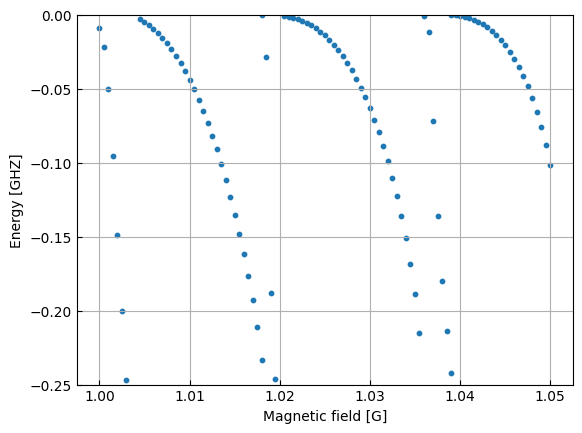

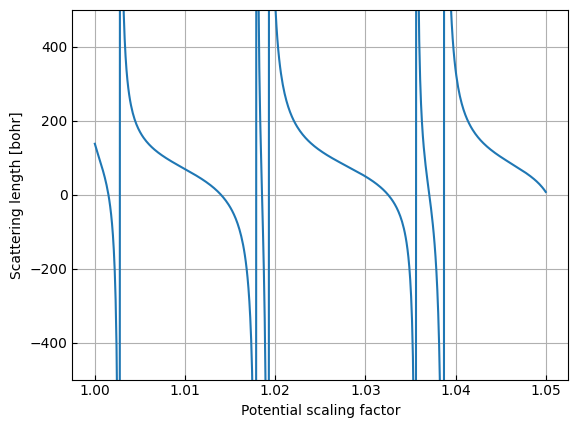

In [17]:
filename = f"{DATA_PATH}/srf_rb_bounds_scale_n_1_singlet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Magnetic field [G]")
ax.set_ylim(-0.25, 0)
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_bounds_n_1_singlet.pdf")

####################################

data = utility.load(f"{DATA_PATH}/srf_rb_potential_scaling_n_max_1.dat")
scalings = data[:, 0]
singlet = data[:, 1]
triplet = data[:, 2]

fig, ax = utility.plot()
ax.plot(scalings, singlet)
# ax.plot(scalings, triplet)

ax.set_ylim(-500, 500)
ax.set_xlabel("Potential scaling factor")
ax.set_ylabel("Scattering length [bohr]");
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_scattering_n_1_singlet.pdf")

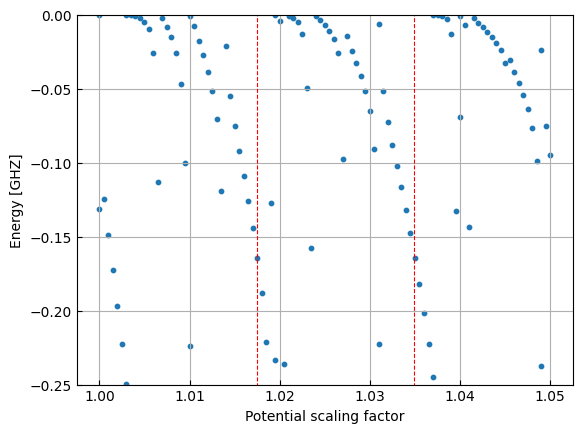

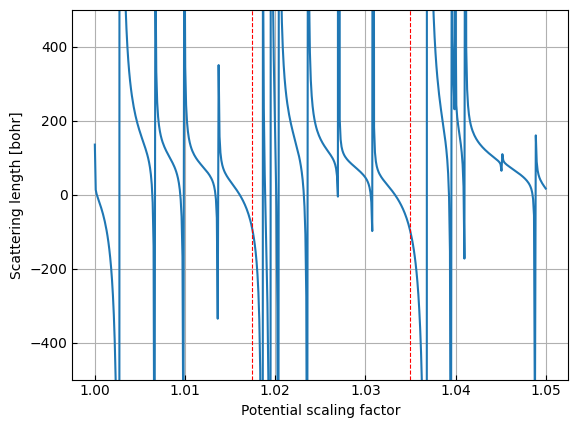

In [ ]:
filename = f"{DATA_PATH}/srf_rb_bounds_scale_n_5_singlet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.vlines([1.0174797334102, 1.0349451752971], [-500], [500], color = "red", linestyles="--", linewidth=0.8)

ax.scatter(field_points, energy_points, s = 10)
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_ylim(-0.25, 0)
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_bounds_n_5_singlet.pdf")

####################################

data = utility.load(f"{DATA_PATH}/srf_rb_potential_scaling_n_max_5.dat")
scalings = data[:, 0]
singlet = data[:, 1]
triplet = data[:, 2]

fig, ax = utility.plot()
ax.plot(scalings, singlet)

ax.vlines([1.0174797334102, 1.0349451752971], [-500], [500], color = "red", linestyles="--", linewidth=0.8)

ax.set_ylim(-500, 500)
ax.set_xlabel("Potential scaling factor")
ax.set_ylabel("Scattering length [bohr]");
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_scattering_n_5_singlet.pdf")

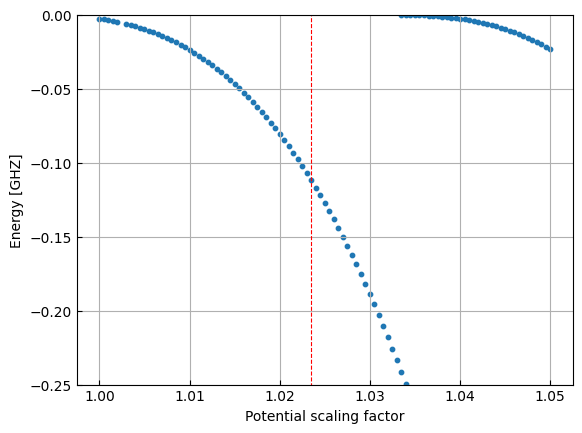

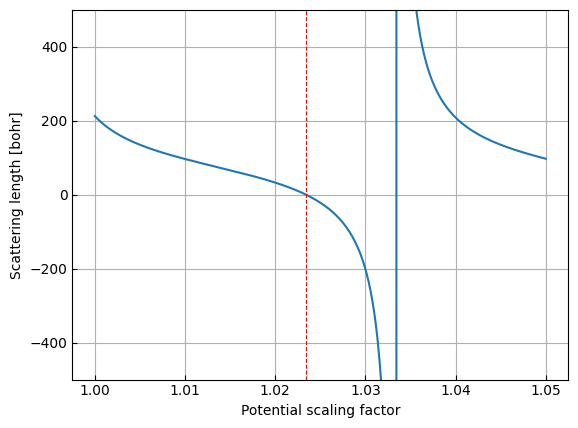

In [ ]:
filename = f"{DATA_PATH}/srf_rb_bounds_scale_n_0_triplet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.vlines([1.0234326602081], [-500], [500], color = "red", linestyles="--", linewidth=0.8)

ax.scatter(field_points, energy_points, s = 10)
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_ylim(-0.25, 0)
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_bounds_n_0_triplet.pdf")

####################################

data = utility.load(f"{DATA_PATH}/srf_rb_potential_scaling_n_max_0.dat")
scalings = data[:, 0]
singlet = data[:, 1]
triplet = data[:, 2]

fig, ax = utility.plot()
ax.plot(scalings, triplet)
ax.vlines([1.0234326602081], [-500], [500], color = "red", linestyles="--", linewidth=0.8)

ax.set_ylim(-500, 500)
ax.set_xlabel("Potential scaling factor")
ax.set_ylabel("Scattering length [bohr]");
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_scattering_n_0_triplet.pdf")

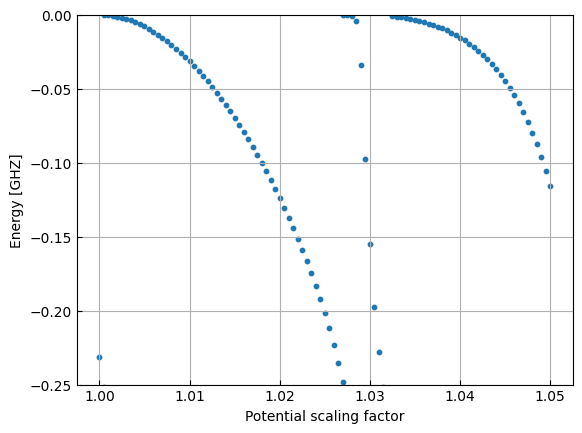

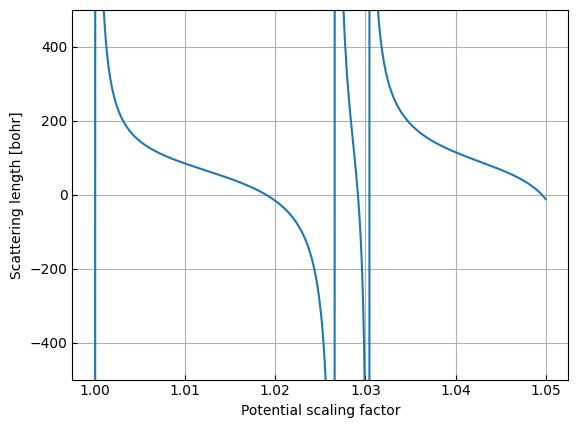

In [ ]:
filename = f"{DATA_PATH}/srf_rb_bounds_scale_n_1_triplet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_ylim(-0.25, 0)
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_bounds_n_1_triplet.pdf")

####################################

data = utility.load(f"{DATA_PATH}/srf_rb_potential_scaling_n_max_1.dat")
scalings = data[:, 0]
singlet = data[:, 1]
triplet = data[:, 2]

fig, ax = utility.plot()
ax.plot(scalings, triplet)

ax.set_ylim(-500, 500)
ax.set_xlabel("Potential scaling factor")
ax.set_ylabel("Scattering length [bohr]");
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_scattering_n_1_triplet.pdf")

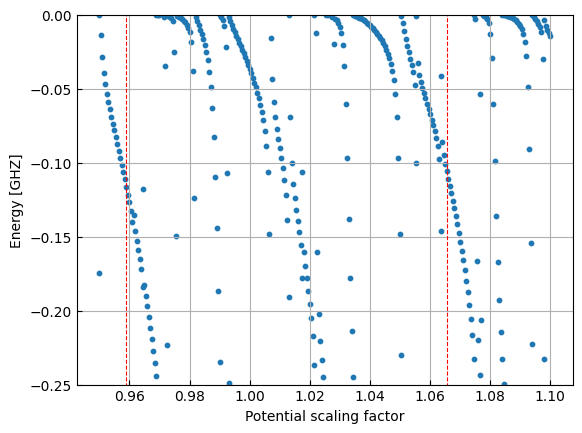

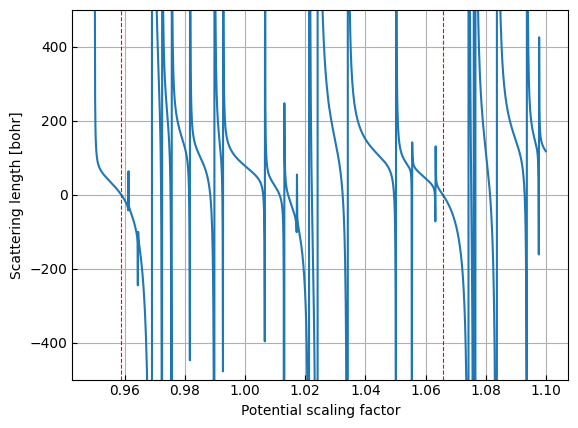

In [ ]:
filename = f"{DATA_PATH}/srf_rb_bounds_scale_n_5_triplet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.vlines([0.9587806804328, 1.0657638160382], [-500], [500], color = "red", linestyles="--", linewidth=0.8)

ax.scatter(field_points, energy_points, s = 10)
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_ylim(-0.25, 0)
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_bounds_n_5_triplet.pdf")

####################################

data = utility.load(f"{DATA_PATH}/srf_rb_potential_scaling_n_max_5_extended.dat")
scalings = data[:, 0]
singlet = data[:, 1]
triplet = data[:, 2]

fig, ax = utility.plot()
ax.plot(scalings, triplet)
ax.vlines([0.9587806804328, 1.0657638160382], [-500], [500], color = "red", linestyles="--", linewidth=0.8)

ax.set_ylim(-500, 500)
ax.set_xlabel("Potential scaling factor")
ax.set_ylabel("Scattering length [bohr]");
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_pot_scaling_scattering_n_5_triplet.pdf")

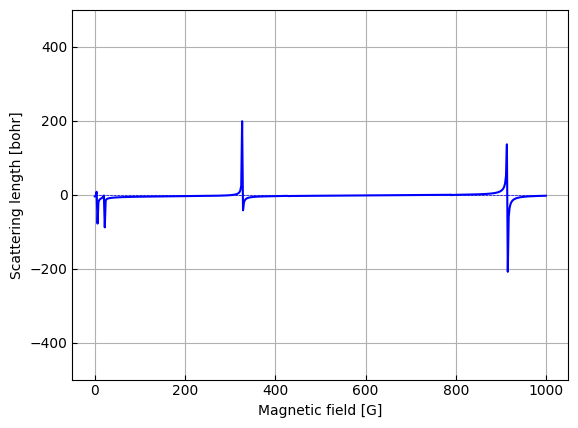

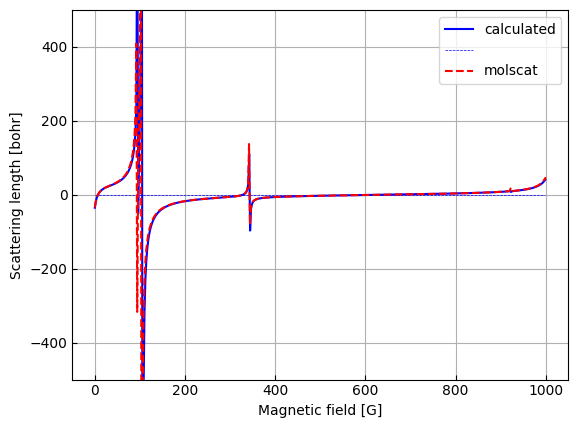

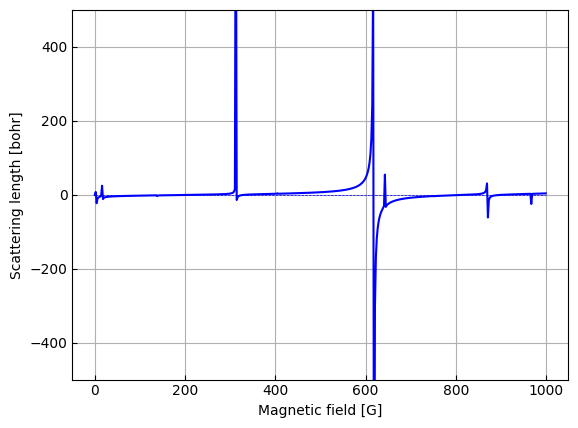

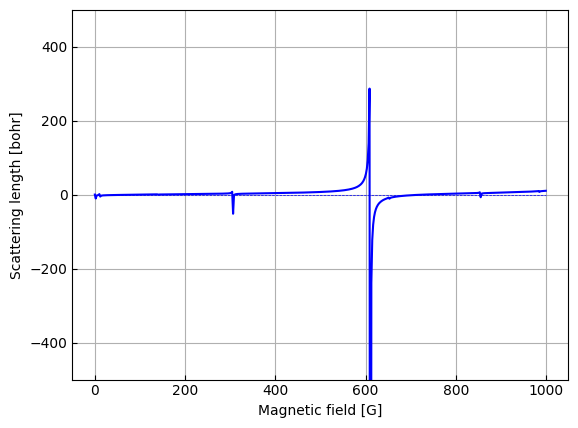

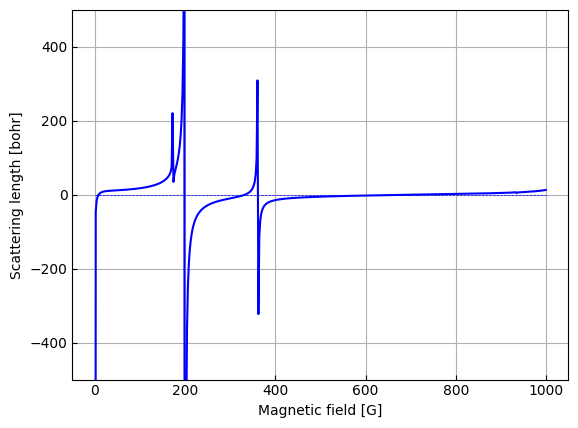

In [ ]:
data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scaled_scattering_n_0.json")

n = len(data.parameters)
n_half = n // 2
points = data.parameters[0:n_half]
lengths = data.s_lengths()[0:n_half]

fig, ax = utility.plot()
ax.plot(points, lengths.real, color = "blue")
ax.plot(points, lengths.imag, color = "blue", linestyle="--", linewidth = 0.5)

ax.set_ylim(-500, 500)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Scattering length [bohr]")
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_scattering_n_0_scaled.pdf")

data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scaled_scattering_n_5.json")

n = len(data.parameters)
n_half = n // 2
points = data.parameters[0:n_half]
lengths = data.s_lengths()[0:n_half]

fig, ax = utility.plot()
ax.plot(points, lengths.real, color = "blue")
ax.plot(points, lengths.imag, color = "blue", linestyle="--", linewidth = 0.5)

try:
	data = read_molscat_field_dependence(f"{DATA_PATH}/srf_rb_scattering_n_5_scaled_molscat.3")
	ax.plot(data[:, 0], data[:, 1], color = "red", label="molscat", linestyle="--")
	ax.legend(["calculated", "", "molscat"])
except:
	pass

ax.set_ylim(-500, 500)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Scattering length [bohr]")
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_scattering_n_5_scaled.pdf")

data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scaled_scattering_n_5_v2.json")

n = len(data.parameters)
n_half = n // 2
points = data.parameters[0:n_half]
lengths = data.s_lengths()[0:n_half]

fig, ax = utility.plot()
ax.plot(points, lengths.real, color = "blue")
ax.plot(points, lengths.imag, color = "blue", linestyle="--", linewidth = 0.5)

ax.set_ylim(-500, 500)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Scattering length [bohr]");
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_scattering_n_5_scaled_v2.pdf")

data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scaled_scattering_n_5_v3.json")

n = len(data.parameters)
n_half = n // 2
points = data.parameters[0:n_half]
lengths = data.s_lengths()[0:n_half]

fig, ax = utility.plot()
ax.plot(points, lengths.real, color = "blue")
ax.plot(points, lengths.imag, color = "blue", linestyle="--", linewidth = 0.5)

ax.set_ylim(-500, 500)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Scattering length [bohr]");
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_scattering_n_5_scaled_v3.pdf")

data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scaled_scattering_n_5_v4.json")

n = len(data.parameters)
n_half = n // 2
points = data.parameters[0:n_half]
lengths = data.s_lengths()[0:n_half]

fig, ax = utility.plot()
ax.plot(points, lengths.real, color = "blue")
ax.plot(points, lengths.imag, color = "blue", linestyle="--", linewidth = 0.5)

ax.set_ylim(-500, 500)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Scattering length [bohr]");
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_scattering_n_5_scaled_v4.pdf")

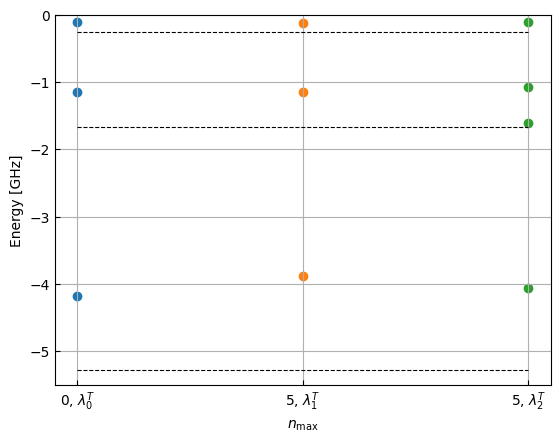

In [ ]:
fig, ax = utility.plot()

bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_0_triplet_a0.dat")
ax.scatter([r"0, $\lambda^T_0$" for _ in bounds], bounds)

bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_5_triplet_a0.dat")
ax.scatter([r"5, $\lambda^T_1$" for _ in bounds], bounds)

bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_5_triplet_a0_v2.dat")
ax.scatter([r"5, $\lambda^T_2$" for _ in bounds], bounds)

x = [r"0, $\lambda^T_0$", r"5, $\lambda^T_1$", r"5, $\lambda^T_2$"]
for value in [0.246, 1.660, 5.280]:
	ax.plot(x, [-value for _ in range(3)], linestyle="--", color="black", linewidth=0.8)

ax.set_ylabel("Energy [GHz]")
ax.set_xlabel(r"$n_\text{max}$");
ax.set_ylim(-5.5, 0);
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_bounds_triplet_a0.pdf")

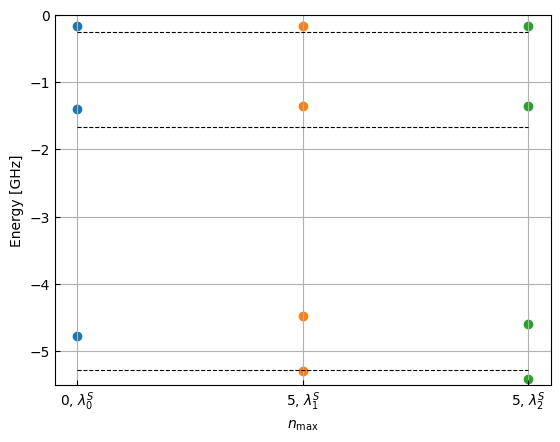

In [ ]:
fig, ax = utility.plot()

bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_0_singlet_a0.dat")
ax.scatter([r"0, $\lambda^S_0$" for _ in bounds], bounds)

bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_5_singlet_a0.dat")
ax.scatter([r"5, $\lambda^S_1$" for _ in bounds], bounds)

bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_5_singlet_a0_v2.dat")
ax.scatter([r"5, $\lambda^S_2$" for _ in bounds], bounds)

x = [r"0, $\lambda^S_0$", r"5, $\lambda^S_1$", r"5, $\lambda^S_2$"]
for value in [0.246, 1.660, 5.280]:
	ax.plot(x, [-value for _ in range(3)], linestyle="--", color="black", linewidth=0.8)

ax.set_ylabel("Energy [GHz]")
ax.set_xlabel(r"$n_\text{max}$");
ax.set_ylim(-5.5, 0);
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_bounds_singlet_a0.pdf")

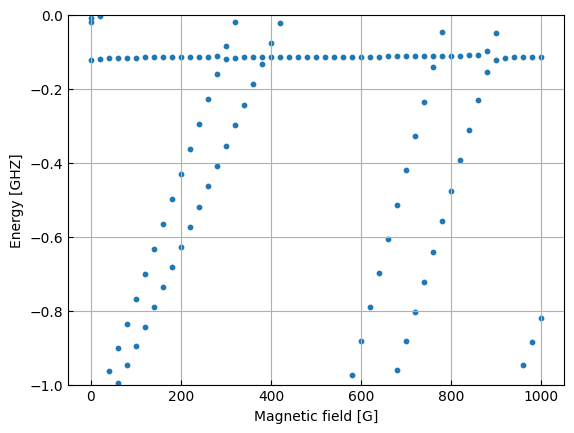

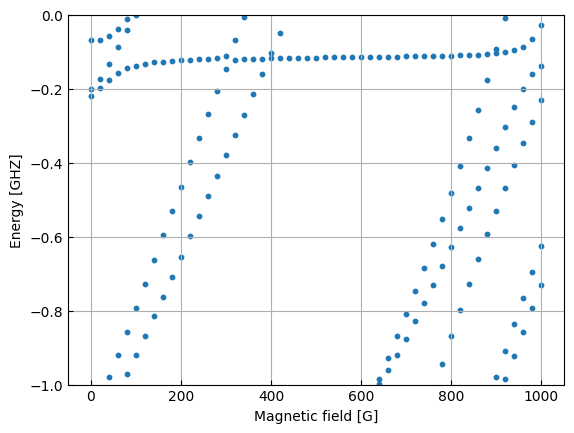

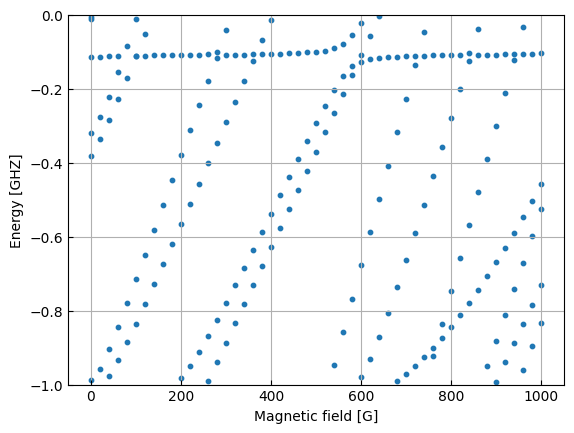

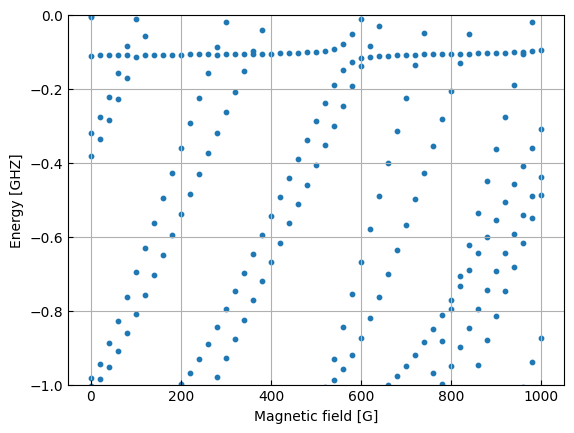

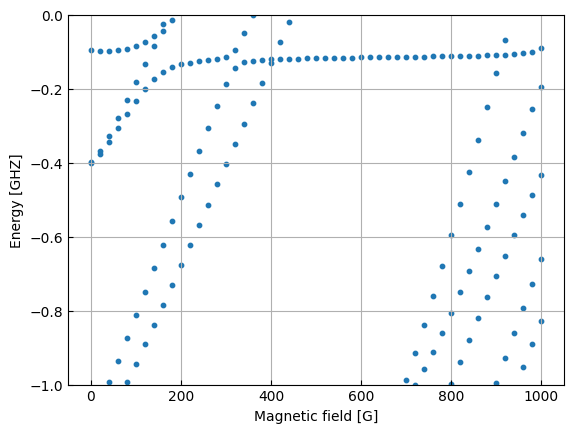

In [ ]:
filename = f"{DATA_PATH}/srf_rb_bounds_n_0_scale_molscat.output"
data, unit = get_bound_energies(filename, parameter=Parameter.MagneticField)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()

ax.scatter(field_points, energy_points, s = 10)
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Magnetic field [G]")
ax.set_ylim(-1, 0)
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_bounds_n_0_scaled.pdf")

filename = f"{DATA_PATH}/srf_rb_bounds_n_5_scale_molscat.output"
data, unit = get_bound_energies(filename, parameter=Parameter.MagneticField)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()

ax.scatter(field_points, energy_points, s = 10)
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Magnetic field [G]")
ax.set_ylim(-1, 0)
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_bounds_n_5_scaled.pdf")

filename = f"{DATA_PATH}/srf_rb_bounds_n_5_scale_molscat_v2.output"
data, unit = get_bound_energies(filename, parameter=Parameter.MagneticField)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()

ax.scatter(field_points, energy_points, s = 10)
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Magnetic field [G]")
ax.set_ylim(-1, 0)
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_bounds_n_5_scaled_v2.pdf")

filename = f"{DATA_PATH}/srf_rb_bounds_n_5_scale_molscat_v3.output"
data, unit = get_bound_energies(filename, parameter=Parameter.MagneticField)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()

ax.scatter(field_points, energy_points, s = 10)
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Magnetic field [G]")
ax.set_ylim(-1, 0)
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_bounds_n_5_scaled_v3.pdf")

filename = f"{DATA_PATH}/srf_rb_bounds_n_5_scale_molscat_v4.output"
data, unit = get_bound_energies(filename, parameter=Parameter.MagneticField)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()

ax.scatter(field_points, energy_points, s = 10)
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Magnetic field [G]")
ax.set_ylim(-1, 0)
# fig.savefig(f"{SAVE_PATH}/SrF_Rb_bounds_n_5_scaled_v4.pdf")

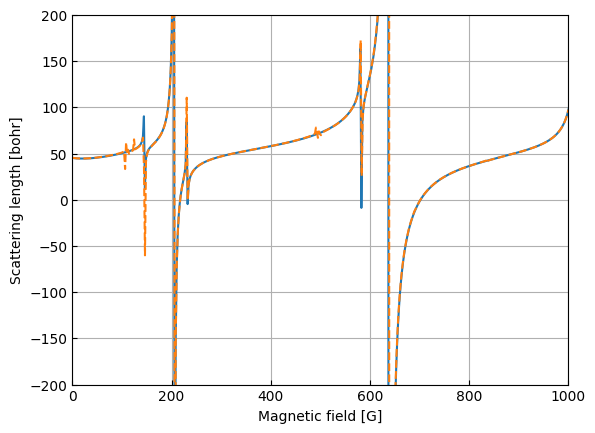

In [10]:
fig, ax = utility.plot()

data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scatterings_ground_n_max_10_n_tot_0.json")
ax.plot(data.parameters, data.s_lengths().real)

data = ScatteringDependence.parse_json(f"{DATA_PATH}/SrF_Rb_scatterings_ground_n_max_10_n_tot_1.json")
ax.plot(data.parameters, data.s_lengths().real, linestyle="--")

ax.set_ylim(-200, 200)
ax.set_xlim(0, 1000)
ax.set_xlabel("Magnetic field [G]")
ax.set_ylabel("Scattering length [bohr]");

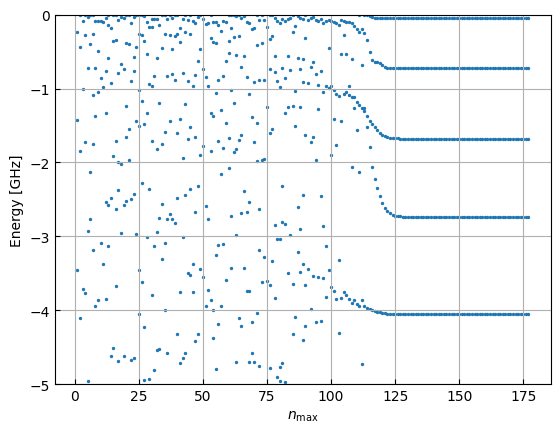

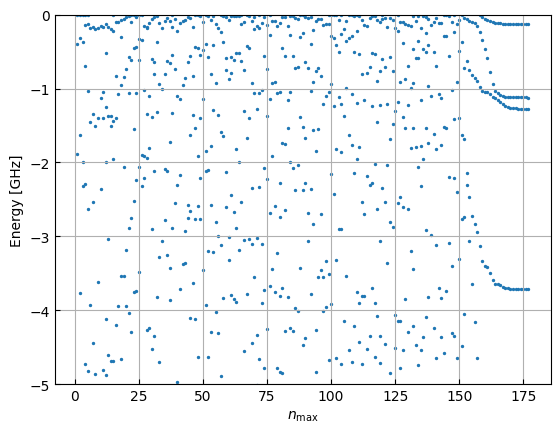

In [3]:
filename = f"{DATA_PATH}/srf_rb_bounds_n_max_triplet.dat"
data = np.loadtxt(filename, delimiter="\t", skiprows=1)

fig, ax = utility.plot()
ax.scatter(data[:, 0], data[:, 1], s=2)

ax.set_xlabel(r"$n_\text{max}$")
ax.set_ylabel("Energy [GHz]")
ax.set_ylim(-5, 0);
fig.savefig(f"{SAVE_PATH}/srf_rb_bounds_n_max_triplet.pdf")

filename = f"{DATA_PATH}/srf_rb_bounds_n_max_singlet.dat"
data = np.loadtxt(filename, delimiter="\t", skiprows=1)

fig, ax = utility.plot()
ax.scatter(data[:, 0], data[:, 1], s=2)

ax.set_xlabel(r"$n_\text{max}$")
ax.set_ylabel("Energy [GHz]")
ax.set_ylim(-5, 0);
fig.savefig(f"{SAVE_PATH}/srf_rb_bounds_n_max_singlet.pdf")

# N_max = 5, potential scaling

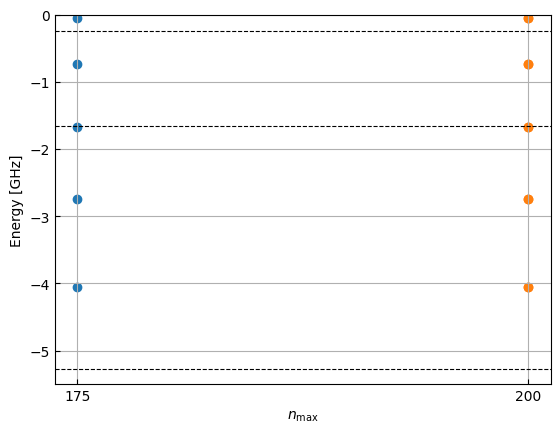

In [ ]:
fig, ax = utility.plot()

bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_triplet.dat")
ax.scatter([r"175" for _ in bounds], bounds)

bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_200_triplet.dat")
ax.scatter([r"200" for _ in bounds], bounds)

for value in [0.246, 1.660, 5.280]:
	ax.axhline(-value, linestyle="--", color="black", linewidth=0.8)

ax.set_ylabel("Energy [GHz]")
ax.set_xlabel(r"$n_\text{max}$");
ax.set_ylim(-5.5, 0);

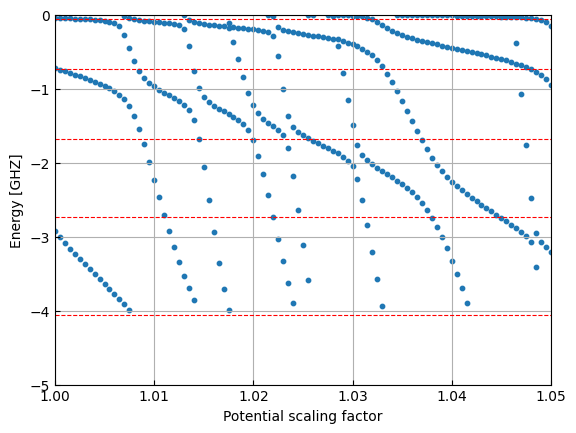

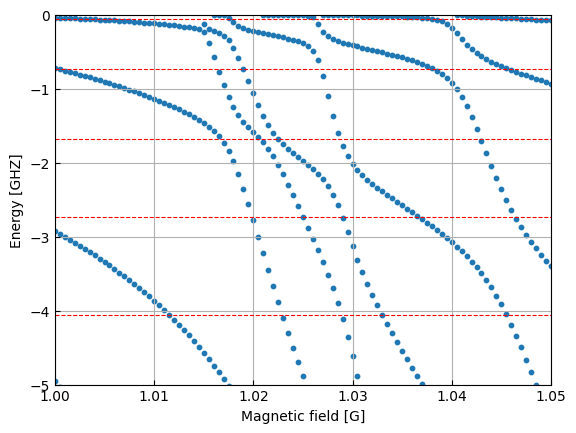

In [4]:
bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_triplet.dat")

filename = f"{DATA_PATH}/srf_rb_bounds_scale_n_5_triplet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-5, 0);

# filename = f"{DATA_PATH}/srf_rb_bounds_aniso_scaling_triplet_n_5.output"
# data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

# field_points = []
# energy_points = []
# for field, energies in data:
#     for energy in energies:
#         field_points.append(field)
#         energy_points.append(energy)
        
# fig, ax = utility.plot()
# ax.scatter(field_points, energy_points, s = 10)

# for b in bounds:
# 	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)
     
# ax.set_ylabel(f"Energy [{unit}]")
# ax.set_xlabel("Magnetic field [G]")
# ax.set_xlim(1.0, 1.05)
# ax.set_ylim(-5, 0);

filename = f"{DATA_PATH}/srf_rb_bounds_iso_scaling_n_5_triplet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)
     
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Magnetic field [G]")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-5, 0);

# filename = f"{DATA_PATH}/srf_rb_lambda_2_scaling_n_5_triplet_extended.output"
# data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

# field_points = []
# energy_points = []
# for field, energies in data:
#     for energy in energies:
#         field_points.append(field)
#         energy_points.append(energy)
        
# fig, ax = utility.plot()
# ax.scatter(field_points, energy_points, s = 10)

# for b in bounds:
# 	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

# ax.set_ylabel(f"Energy [{unit}]")
# ax.set_xlabel("Potential scaling factor")
# # ax.set_xlim(1.0, 1.05)
# ax.set_ylim(-5, 0);

# filename = f"{DATA_PATH}/srf_rb_lambda_10_scaling_n_5_triplet_extended.output"
# data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

# field_points = []
# energy_points = []
# for field, energies in data:
#     for energy in energies:
#         field_points.append(field)
#         energy_points.append(energy)
        
# fig, ax = utility.plot()
# ax.scatter(field_points, energy_points, s = 10)

# for b in bounds:
# 	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

# ax.set_ylabel(f"Energy [{unit}]")
# ax.set_xlabel("Potential scaling factor")
# # ax.set_xlim(1.0, 1.05)
# ax.set_ylim(-5, 0);

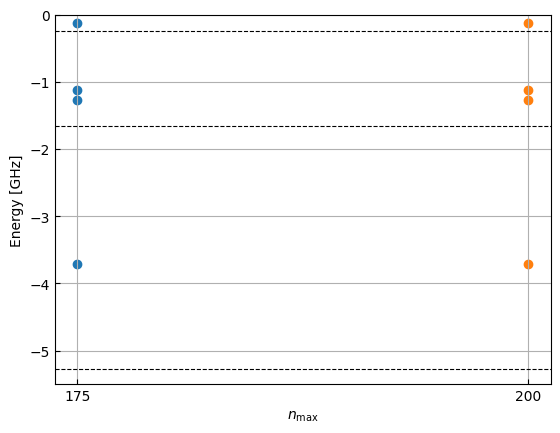

In [11]:
fig, ax = utility.plot()

bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_singlet.dat")
ax.scatter([r"175" for _ in bounds], bounds)

bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_200_singlet.dat")
ax.scatter([r"200" for _ in bounds], bounds)

for value in [0.246, 1.660, 5.280]:
	ax.axhline(-value, linestyle="--", color="black", linewidth=0.8)

ax.set_ylabel("Energy [GHz]")
ax.set_xlabel(r"$n_\text{max}$");
ax.set_ylim(-5.5, 0);

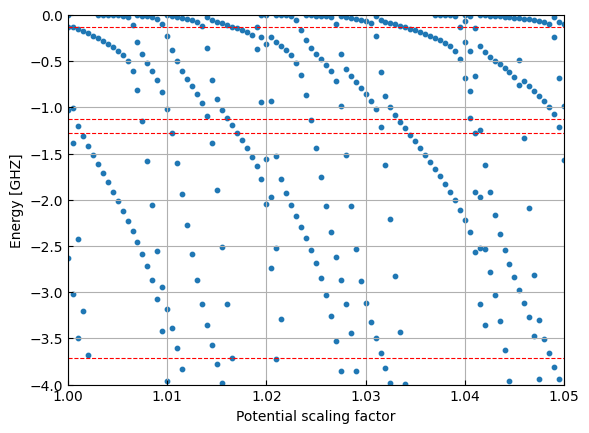

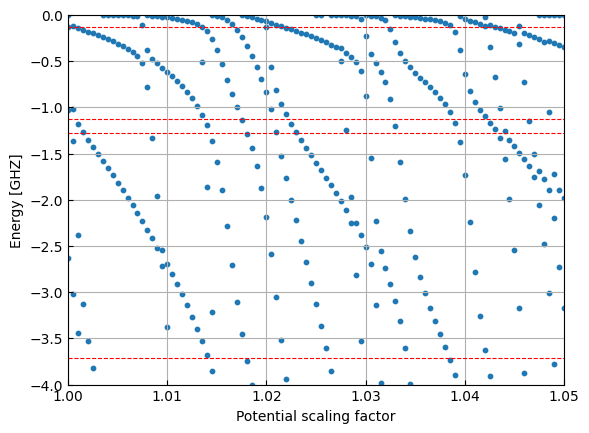

In [5]:
bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_singlet.dat")

filename = f"{DATA_PATH}/srf_rb_bounds_scale_n_5_singlet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

# filename = f"{DATA_PATH}/srf_rb_bounds_aniso_scaling_singlet_n_5.output"
# data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

# field_points = []
# energy_points = []
# for field, energies in data:
#     for energy in energies:
#         field_points.append(field)
#         energy_points.append(energy)
        
# fig, ax = utility.plot()
# ax.scatter(field_points, energy_points, s = 10)

# for b in bounds:
# 	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)
     
# ax.set_ylabel(f"Energy [{unit}]")
# ax.set_xlabel("Magnetic field [G]")
# ax.set_xlim(1.0, 1.05)
# ax.set_ylim(-4, 0);

filename = f"{DATA_PATH}/srf_rb_bounds_iso_scaling_n_5_singlet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

# filename = f"{DATA_PATH}/srf_rb_lambda_2_scaling_n_5_singlet_extended.output"
# data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

# field_points = []
# energy_points = []
# for field, energies in data:
#     for energy in energies:
#         field_points.append(field)
#         energy_points.append(energy)
        
# fig, ax = utility.plot()
# ax.scatter(field_points, energy_points, s = 10)

# for b in bounds:
# 	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

# ax.set_ylabel(f"Energy [{unit}]")
# ax.set_xlabel("Potential scaling factor")
# # ax.set_xlim(1.0, 1.05)
# ax.set_ylim(-4, 0);

# filename = f"{DATA_PATH}/srf_rb_lambda_10_scaling_n_5_singlet_extended.output"
# data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

# field_points = []
# energy_points = []
# for field, energies in data:
#     for energy in energies:
#         field_points.append(field)
#         energy_points.append(energy)
        
# fig, ax = utility.plot()
# ax.scatter(field_points, energy_points, s = 10)

# for b in bounds:
# 	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

# ax.set_ylabel(f"Energy [{unit}]")
# ax.set_xlabel("Potential scaling factor")
# # ax.set_xlim(1.0, 1.05)
# ax.set_ylim(-4, 0);

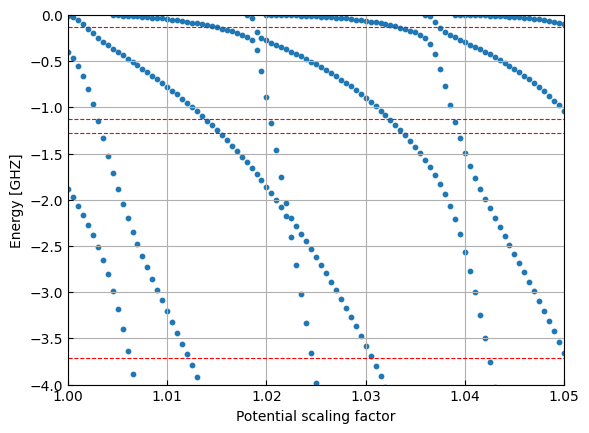

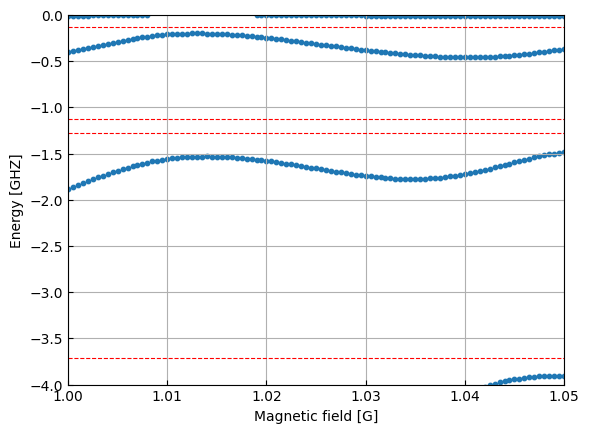

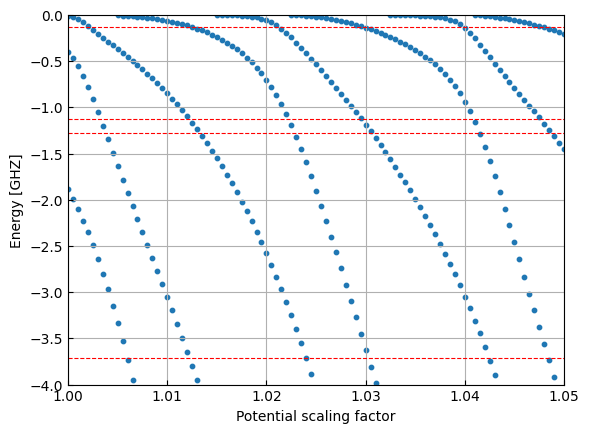

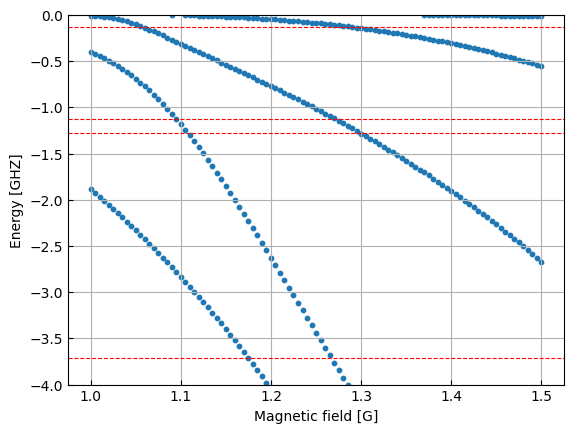

In [6]:
bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_singlet.dat")

filename = f"{DATA_PATH}/srf_rb_bounds_scaling_n_1_singlet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

filename = f"{DATA_PATH}/srf_rb_bounds_aniso_scaling_n_1_singlet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)
     
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Magnetic field [G]")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

filename = f"{DATA_PATH}/srf_rb_bounds_iso_scaling_n_1_singlet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

filename = f"{DATA_PATH}/srf_rb_lambda_2_scaling_n_1_singlet_extended.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)
     
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Magnetic field [G]")
# ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

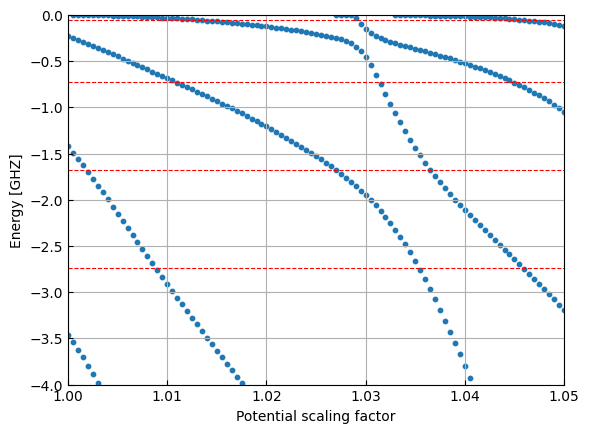

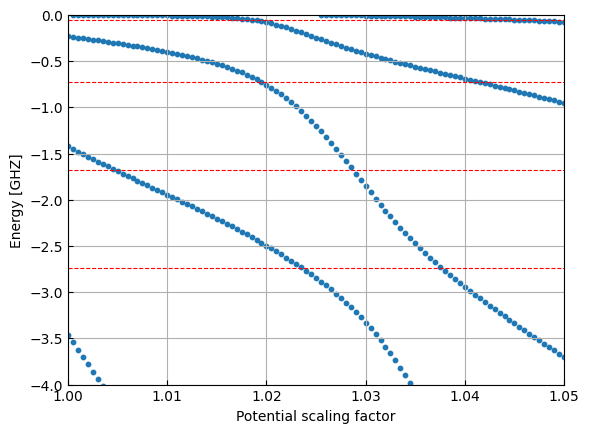

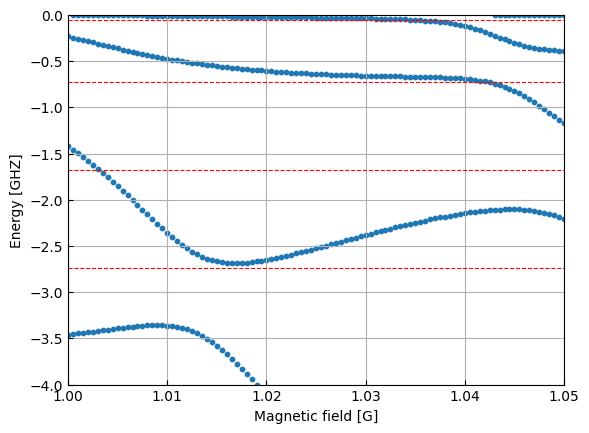

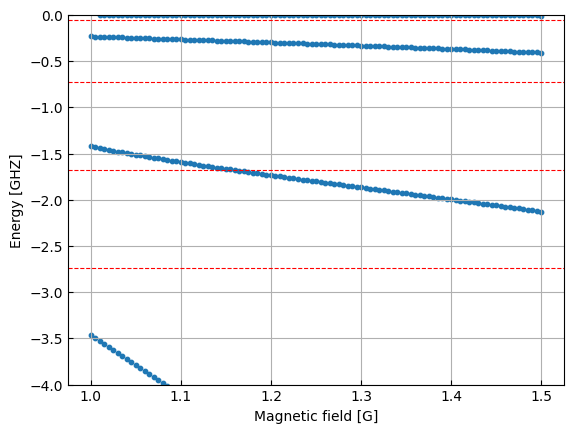

In [30]:
bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_triplet.dat")

filename = f"{DATA_PATH}/srf_rb_bounds_scaling_n_1_triplet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

filename = f"{DATA_PATH}/srf_rb_bounds_iso_scaling_n_1_triplet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

filename = f"{DATA_PATH}/srf_rb_bounds_aniso_scaling_n_1_triplet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)
     
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Magnetic field [G]")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

filename = f"{DATA_PATH}/srf_rb_lambda_2_scaling_n_1_triplet_extended.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)
     
ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Magnetic field [G]")
# ax.set_xlim(1.0, 1.05) 
ax.set_ylim(-4, 0);

# N_max = 10, potential scaling, iso potential scaling

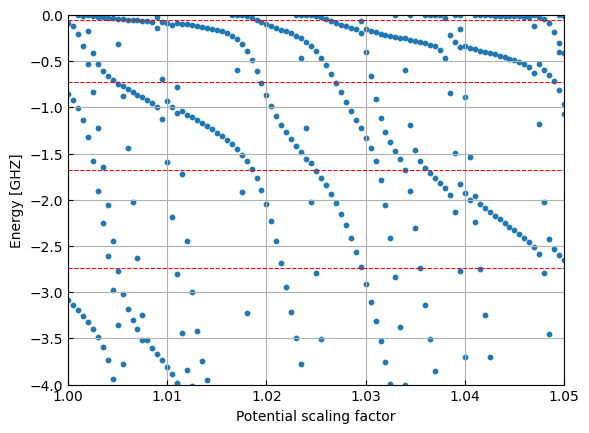

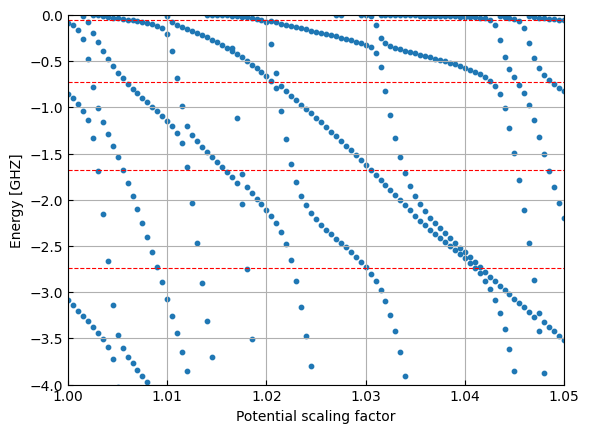

In [16]:
bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_triplet.dat")

filename = f"{DATA_PATH}/srf_rb_bounds_scaling_n_10_triplet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)

fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

filename = f"{DATA_PATH}/srf_rb_bounds_iso_scaling_n_10_triplet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

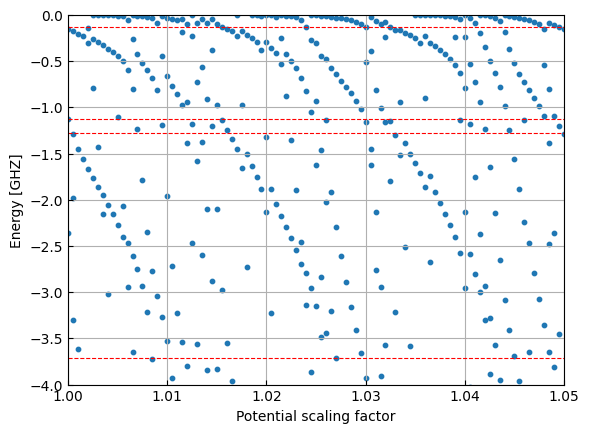

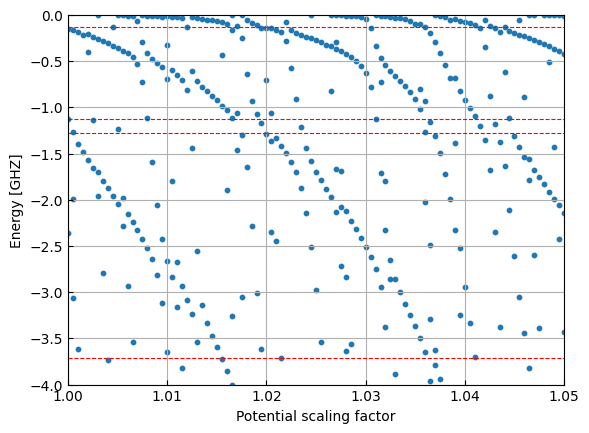

In [17]:
bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_singlet.dat")

filename = f"{DATA_PATH}/srf_rb_bounds_scaling_n_10_singlet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

filename = f"{DATA_PATH}/srf_rb_bounds_iso_scaling_n_10_singlet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)
        
fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

# N_max = 10 vs N_max = 5

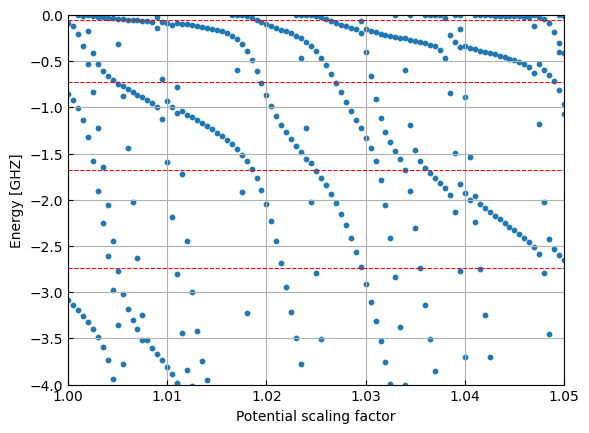

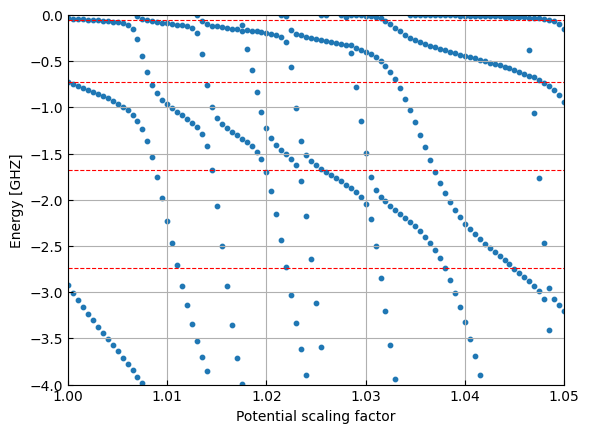

In [20]:
bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_triplet.dat")

filename = f"{DATA_PATH}/srf_rb_bounds_scaling_n_10_triplet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)

fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

filename = f"{DATA_PATH}/srf_rb_bounds_scale_n_5_triplet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)

fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

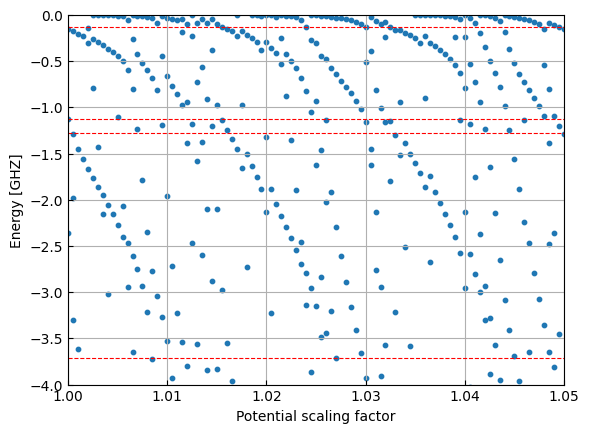

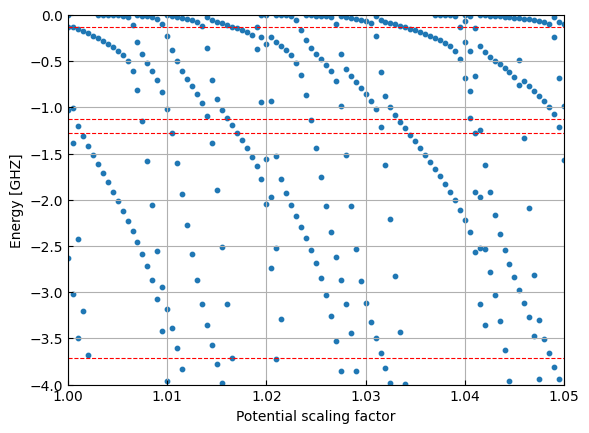

In [21]:
bounds = np.loadtxt(f"{DATA_PATH}/srf_rb_bounds_n_175_singlet.dat")

filename = f"{DATA_PATH}/srf_rb_bounds_scaling_n_10_singlet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)

fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);

filename = f"{DATA_PATH}/srf_rb_bounds_scale_n_5_singlet.output"
data, unit = get_bound_energies(filename, parameter=Parameter.ScalingFactor)

field_points = []
energy_points = []
for field, energies in data:
    for energy in energies:
        field_points.append(field)
        energy_points.append(energy)

fig, ax = utility.plot()
ax.scatter(field_points, energy_points, s = 10)

for b in bounds:
	ax.axhline(b, color = "red", linestyle="--", linewidth=0.8)

ax.set_ylabel(f"Energy [{unit}]")
ax.set_xlabel("Potential scaling factor")
ax.set_xlim(1.0, 1.05)
ax.set_ylim(-4, 0);